# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [4]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

# Math
import math as m

# Pylab
import pylab

# Numpy.linalg
import numpy.linalg as alg


### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [5]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [6]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [7]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [5]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [8]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [9]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

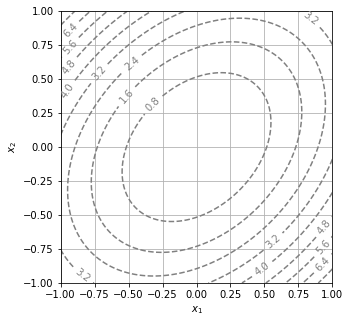

In [10]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [11]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

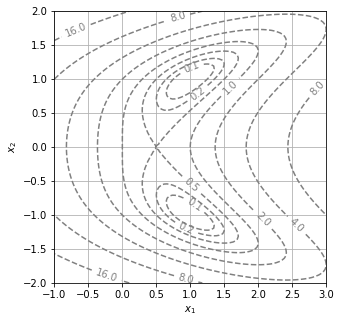

In [12]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [13]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

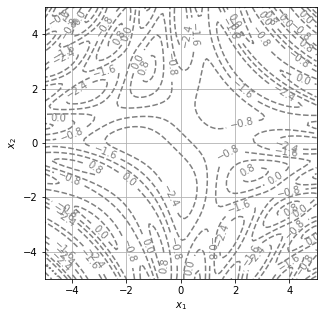

In [14]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [15]:
N = 100
eps = 10**-4

# Explication du choix
print("Explication : choisir la valeur de eps est un compromis entre précision de la solution trouvée et temps de covergence de la méthode de Newton.\nIl faut donc choisir eps ni trop grand, ni trop petit.\n\nAprès implémentation de la fonction Newton, en faisant varier la valeur de eps, nous avons remaquer que la précision de la solution était généralement du même nombre de décimale que eps.\n\nCONCLUSION :\neps = 10**-6 est une précison intéressante\nN = 1000 permettra, si besoin, de limiter le nombre d'itérations")

delta = 0.05

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [16]:
def Newton(F, x0, y0, eps=eps, N=N):
    for i in range(N):
        resol_sys = - alg.solve(J(F)(x0,y0),F(x0,y0))
        # On supposera que F renvoye un ndarray
        x, y = x0 + resol_sys[0] , y0 + resol_sys[1]
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

TESTS SUR LA METHODE DE NEWTON

1)Une solution de l'équation f1(x,y) = 0.8, et vérifiant en outre y - x = 0, est (3.814697265625e-07, 3.814697265625e-07) pour un point de référence (0.8,0.8)


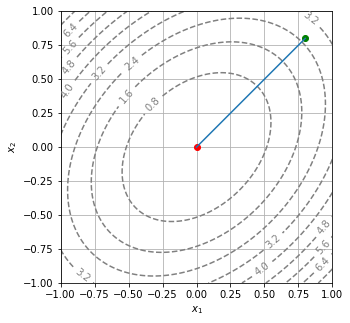

In [53]:
# Exemple avec la contrainte supplémentaire y = x et avec un point de référence d'abord vallant(0.8,0.8), puis variant.
def F1(x,y):
    return np.array([f1(x,y),y-x])

sol1 = Newton(F1, 1.0, 1.0, eps, N)

# Recherche d'un point de la ligne de niveau 0.8 par la méthode de Newton
def recherche_solution_ligne_de_niveau():
    print("TESTS SUR LA METHODE DE NEWTON\n")
    sol1 = Newton(F1,0.8,0.8, eps = 10**-6, N = 1000)
    print(f"1)Une solution de l'équation f1(x,y) = 0.8, et vérifiant en outre y - x = 0, est {sol1} pour un point de référence (0.8,0.8)")
    X, Y = np.meshgrid(np.linspace(-1.0, 1.0, 100), np.linspace(-1.0, 1.0, 100))
    Z = f1(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(X, Y, Z, colors="grey", linestyles="dashed", levels=10)
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

    plt.plot(sol1[0],sol1[1], marker="o", color="red")
    plt.plot(0.8,0.8, marker="o", color="green")
    plt.plot([0.8,sol1[0]],[0.8, sol1[1]])
    plt.show()

recherche_solution_ligne_de_niveau()

2)Ci-dessous une représentation graphique des solutions associées à un point de référence qui peut varier.
Les points de référence sont marqués en vert et sont reliés à leurs solutions associées marquées en rouge.
Interprétation :
-pour un point de référence sur la 1ère bissectrice la solution est dans le plan (x>0, y >0)
-pour un point de référence sur la 3e bissectrice la solution est dans le plan (x<0, y <0)

Remarque : si le point de référence est (x0,y0) = (0.,0.) alg.solv renvoie une erreur - singular Matrix - ne sachant pas quelle solution choisir.


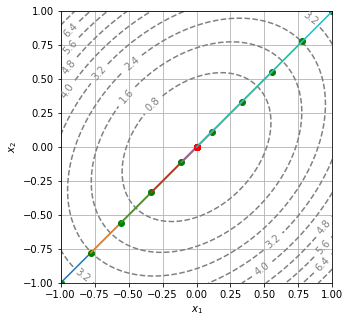

In [54]:
# Variation du point de référence
def variation_du_point_de_reference_et_solution_associee():
    print('2)Ci-dessous une représentation graphique des solutions associées à un point de référence qui peut varier.\nLes points de référence sont marqués en vert et sont reliés à leurs solutions associées marquées en rouge.')
    print('Interprétation :\n-pour un point de référence sur la 1ère bissectrice la solution est dans le plan (x>0, y >0)\n-pour un point de référence sur la 3e bissectrice la solution est dans le plan (x<0, y <0)\n\nRemarque : si le point de référence est (x0,y0) = (0.,0.) alg.solv renvoie une erreur - singular Matrix - ne sachant pas quelle solution choisir.')
    X, Y = np.meshgrid(np.linspace(-1.0, 1.0, 100), np.linspace(-1.0, 1.0, 100))
    Z = f1(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(X, Y, Z, colors="grey", linestyles="dashed", levels=10)
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.gca().set_aspect("equal")
    
    nb = 10
    X0 = np.linspace(-1,1,nb)
    for i in range(nb):
        sol = Newton(F1, X0[i], X0[i], eps=10**-6,N=1000)
        plt.plot(sol[0],sol[1], marker="o", color="red")
        plt.plot(X0[i],X0[i], marker="o", color="green")
        plt.plot([X0[i],sol[0]],[X0[i], sol[1]])
    plt.show()

variation_du_point_de_reference_et_solution_associee()

3)On cherche à présent à faire varier la contrainte.
On choisit tout d'abord une contrainte de la forme : y - a*x = 0 en faisant varier le coefficient directeur a entre -1 et 1.

Une première conclusion : la solution trouvée dépend, comme on pouvait s'y attendre, de la deuxième contrainte.


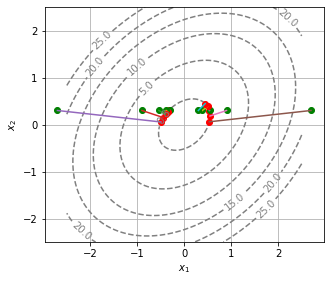

3bis)Testons à présent une contrainte du type y = x + b en faisant varier b entre 0 et 0.6.
Pour b = 0.7, la deuxième contrainte y = x + 0.7 n'aurait pas donnée de solution par la méthode de Newton, puisqu'il n'existe pas de points de la ligne de niveau qui soit également sur cette droite.

Une deuxième conclusion : il faut toujours prendre garde que la deuxième contrainte - qui permet de construire une fonction de R² dans R² pour être dans le cadre de la méthode de Newton - recoupe la ligne de niveau.
Ainsi il n'existe pas de 2e contrainte universelle qui fonctionne pour n'importe quelle fonction. Il faudra toujours posséder des informations supplémentaires sur la fonction pour imaginer une deuxième contrainte compatible.


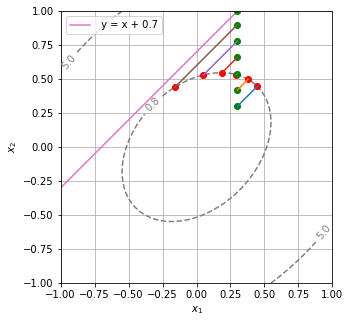

In [55]:
# Variation de la contrainte supplémentaire
def variation_contrainte_supplementaire():
    print("3)On cherche à présent à faire varier la contrainte.\nOn choisit tout d'abord une contrainte de la forme : y - a*x = 0 en faisant varier le coefficient directeur a entre -1 et 1.\n\nUne première conclusion : la solution trouvée dépend, comme on pouvait s'y attendre, de la deuxième contrainte.")
    
    X, Y = np.meshgrid(np.linspace(-2.5, 2.5, 100), np.linspace(-2.5, 2.5, 100))
    Z = f1(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(X, Y, Z, colors="grey", linestyles="dashed", levels=[0.8,5,10,15,20,25])
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")
    
    nb = 10
    listea = np.linspace(-1,1,nb)
    y_ref = 0.3
    liste_x_ref  = y_ref / listea
    for i in range(nb):
        def Fa(x,y):
            return np.array([f1(x,y)- 0.8,y-listea[i] * x])
        sol = Newton(Fa, liste_x_ref[i], y_ref, eps=10**-6,N=1000)
        plt.plot(sol[0],sol[1], marker="o", color="red")
        plt.plot(liste_x_ref[i],y_ref, marker="o", color="green")
        plt.plot([liste_x_ref[i],sol[0]],[y_ref, sol[1]])
    plt.show()
    
    
    print("3bis)Testons à présent une contrainte du type y = x + b en faisant varier b entre 0 et 0.6.\nPour b = 0.7, la deuxième contrainte y = x + 0.7 n'aurait pas donnée de solution par la méthode de Newton, puisqu'il n'existe pas de points de la ligne de niveau qui soit également sur cette droite.\n\nUne deuxième conclusion : il faut toujours prendre garde que la deuxième contrainte - qui permet de construire une fonction de R² dans R² pour être dans le cadre de la méthode de Newton - recoupe la ligne de niveau.\nAinsi il n'existe pas de 2e contrainte universelle qui fonctionne pour n'importe quelle fonction. Il faudra toujours posséder des informations supplémentaires sur la fonction pour imaginer une deuxième contrainte compatible.")
    X, Y = np.meshgrid(np.linspace(-1., 1., 100), np.linspace(-1., 1., 100))
    Z = f1(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(X, Y, Z, colors="grey", linestyles="dashed", levels=[0.8,5,10,15,20,25])
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")
    
    nb = 6
    listeb = np.linspace(0,0.6,nb)
    x_ref = 0.3
    liste_y_ref  = x_ref + listeb
    for i in range(nb):
        def Fb(x,y):
            return np.array([f1(x,y)- 0.8,y - x - listeb[i]])
        sol = Newton(Fb, x_ref, liste_y_ref[i], eps=10**-6,N=1000)
        plt.plot(sol[0],sol[1], marker="o", color="red")
        plt.plot(x_ref,liste_y_ref[i], marker="o", color="green")
        plt.plot([x_ref,sol[0]],[liste_y_ref[i], sol[1]])
    
    Xb07 = np.linspace(-1,0.3,100)
    Yb07 = Xb07 + 0.7
    plt.plot(Xb07, Yb07, label = " y = x + 0.7")
    plt.plot(x_ref,1.0, marker="o", color="green")
    plt.legend()
    plt.show()

variation_contrainte_supplementaire()

no convergence in 100 steps.


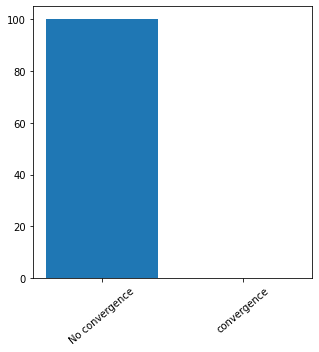

In [22]:
# Troisième contrainte : y = a * x + b , une contrainte linéaire

def Newton_for_conter_no_convergence(F, x0, y0, eps=eps, N=N):
    for i in range(N):
        resol_sys = - alg.solve(J(F)(x0,y0),F(x0,y0))
        # On supposera que F renvoye un ndarray
        x, y = x0 + resol_sys[0] , y0 + resol_sys[1]
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        return f"no convergence in {N} steps."

def F1_ter(x,y):
    return np.array([f1(x,y),y-0.5*x + 0.5])

print(Newton_for_conter_no_convergence(F1ter, 0.1, 0.1, eps,N))

def counter_no_convergence(F, x0, y0, eps=eps, N=N):
    nb = 100
    X0 = np.linspace(-100,100,nb)
    count = 0
    for i in range(nb):
        if Newton_for_conter_no_convergence(F1ter, X0[i], X0[i], eps,N) == f"no convergence in {N} steps.":
            count += 1
    x = [0,1]
    height = [count, nb - count]
    BarName = ['No convergence', 'convergence']
    plt.bar(x , height)
    pylab.xticks(x, BarName, rotation=40)
    plt.show()
    
counter_no_convergence(F1ter, 0.1, 0.1, eps,N)

# Ainsi, il faut faire attention à la contrainte choisie. Si elle est nécessaire pour être dans le cadre du problème de 
# Newton, il faut se souvenir qu'une relation supplémentaire reste une contrainte qui doit être compatible avce les 
# solutions de la première relation.
# Il n'existe pas de contrainte supplémentaire universelle pour que la méthode de Newton procurre automatiquement des 
# solutions de la première contrainte recherchée.

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [ ]:
# Remarque : le point de référence (x0,y0) doit être d'emblée une solution de f(x,y) = c
# En effet, la programmation de la fonction level_curve aurait pu faire apparaître une première phase d'initialisation
# durant laquelle, à partir de point d'un reférence quelconque une première solution est déterminée par la méthode de Newton.
# Cependant il a été vu dans la partie précédente qu'une contrainte supplémentaire ajoutée pour trouver une solution n'est
# jamais universelle.
# Autrement dit il n'existe pas de contrainte universelle permettant de déterminer un premier couple (x0,y0) en phase 
#d'initialisation.

# On dispose d'un point (x0, y0) qui vérifie f(x0, y0)=c, et on veut construire un nouveau point à distance delta de (x0, y0). 
# On prend alors comme deuxième fonction de R2 dans R la fonction cerce de centre (x0, y0) et de rayon delta.
# Pour qu'il soit à droite, on s'oriente sur la tangente en effectuant une rotation de pi/2 
# par rapport à la direction du gradient.


(0.8642102935446413, 0.7233381567956491)


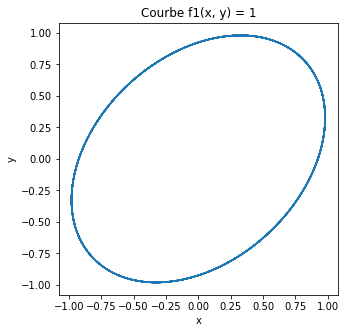

In [25]:
def next_point(f, x0, y0, c, delta=delta):
    
    def F(x, y):
        return np.array([f(x, y) - c, (x-x0)**2 + (y-y0)**2 - delta**2])
    
    g_fx, g_fy = grad(f)(x0, y0)[0], grad(f)(x0, y0)[1]
    norme = m.sqrt(g_fx**2 + g_fy**2)
    x_int, y_int = x0 + delta*g_fy/norme, y0 -delta*g_fx/norme
    x, y = Newton(F, x_int, y_int)
    return x, y


def level_curve(f, x0, y0, delta=delta, N=1000, eps=eps):
    x1, y1 = x0, y0
    l = [[x0, y0]]
    for i in range(N):
        x, y = next_point(f, x1, y1, f(x1, y1))
        x1, y1 = x, y
        l.append([x, y])
    return np.array(l)

print(next_point(f1, 0.8, 0.8, f1(0.8, 0.8), delta=0.1))

l = level_curve(f1, 0.8, 0.8)
plt.figure()
plt.plot(l[:, 0], l[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#On observe ici que la courbe est épaisse, car la fonction level_curve() fait plusieurs fois le tour de la courbe. 

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [26]:
# Pour level_curve_advanced, on exige en plus que la fonction s'arrête si le nouveau point fourni par next_point() est à une 
# distance strictement inférieure à delta (on a pris ici delta/5) et alors on sait qu'on a bouclé la courbe (sauf cas 
# pathologique non-considéré dans ce notebook)

def level_curve_advanced(f, x0, y0, delta=delta, N=1000, eps=eps):
    l = [[x0, y0]]
    for i in range(N):
        x, y = next_point(f, x0, y0, f(x0, y0), delta)
        x0, y0 = x, y
        l.append([x, y])
        if (i>5) and ((x-l[0][0])**2 + (y-l[0][1])**2 < delta/5)  :
            l.append(l[0])
            return np.array(l)
    return np.array(l)

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

<Figure size 360x360 with 0 Axes>

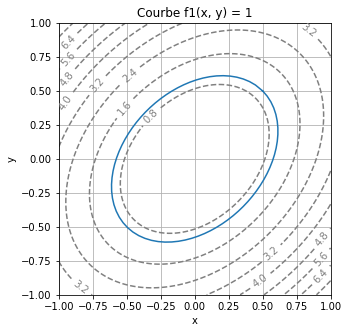

In [27]:
l = level_curve_advanced(f1, 0.5, 0.5, delta)
plt.figure()
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
plt.plot(l[:, 0], l[:, 1])
plt.title('Courbe f1(x, y) = 1')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

<Figure size 360x360 with 0 Axes>

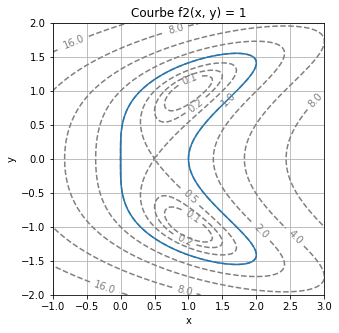

In [28]:
l = level_curve_advanced(f2, 0., 0., delta)
plt.figure()
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
plt.plot(l[:, 0], l[:, 1])
plt.title('Courbe f2(x, y) = 1')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Les lignes de niveau sont ici en plusieurs morceaux de courbes fermées, nous n'avons pu créer qu'une ligne de niveau donnée, et nous avons choisi pour cette représentation f3(x, y)=0


<Figure size 360x360 with 0 Axes>

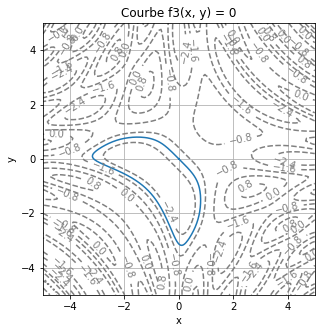

In [29]:
print("""Les lignes de niveau sont ici en plusieurs morceaux de courbes fermées, nous n'avons pu créer qu'une ligne de niveau donnée, et nous avons choisi pour cette représentation f3(x, y)=0""")

l = level_curve_advanced(f3, 0., 0., delta)
plt.figure()
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)
plt.plot(l[:, 0], l[:, 1])
plt.title('Courbe f3(x, y) = 0')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [56]:
def premieres_remarques():
    print("PREMIERES REMARQUES")
    print("- Remarque 1 : On suppose que l'ensemble est borné. Il peut ainsi être plongé dans un carré de plus grande aire.")
    print("- Remarque 2 : il est sous-entendu dans la question que le carré dans lequel l'ensemble est plongé est correctement dimensionné.")
    print("- Remarque 3 : l'ensemble K est quelconque borné. Il peut ainsi être connexe ou seulement connexe par arcs, ou bien posséder plusieurs composantes connexes ou bien plusieurs composantes cpa.")
    print("\nDescription générale de la démarche :\nLa fonction est implémentée en prenant en compte que l'utilisateur peut visualiser grossièrement la forme de la fonction à l'aide d'un display_contour et par conséquent renseigner manuellement les coordonnées de ce carré dans l'argument carre.")

premieres_remarques()

PREMIERES REMARQUES
- Remarque 1 : On suppose que l'ensemble est borné. Il peut ainsi être plongé dans un carré de plus grande aire.
- Remarque 2 : il est sous-entendu dans la question que le carré dans lequel l'ensemble est plongé est correctement dimensionné.
- Remarque 3 : l'ensemble K est quelconque borné. Il peut ainsi être connexe ou seulement connexe par arcs, ou bien posséder plusieurs composantes connexes ou bien plusieurs composantes cpa.

Description générale de la démarche :
La fonction est implémentée en prenant en compte que l'utilisateur peut visualiser grossièrement la forme de la fonction à l'aide d'un display_contour et par conséquent renseigner manuellement les coordonnées de ce carré dans l'argument carre.


In [58]:
## Implémentation
def area_squares(f, c, h, carre):
    """
    carre est un tupple contenant la position du sommet en bas à gauche du carré dans lequel K est plongé et la longeur des côtés.
    Par exemple, carre = ((0.0,1.0),5.0)
    """
    cx0,cy0, cote = carre[0][0], carre[0][1], carre[1]
    Nb = m.ceil(cote/h)
    cotebis = h*Nb
    
    mail1 = np.zeros((Nb+1, Nb+1))
    mail1 += cx0
    colonne_abscisse = np.linspace(0, cotebis, Nb+1)
    mail1 += colonne_abscisse
    
    mail2 = np.zeros((Nb+1, Nb+1))
    mail2 += cx0
    ligne_ordonnee = cotebis - colonne_abscisse.reshape((Nb+1,1))
    mail2 += ligne_ordonnee
    
    maillage = f(mail1,mail2)
    maillage = maillage <= c
    return np.sum(maillage) * h**2


ESTIMATION


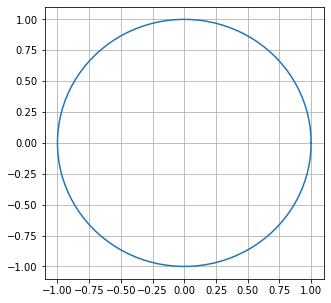

A l'aide de la méthode des carrées, pour un pas de 0.001, l'estimation de l'aire du cercle unité est : 3.141543




In [61]:
def aire_disque_unite(h):
    def f4(x,y):
        return x**2 + y**2
    return area_squares(f4,1,h,((-1.1,-1.1),2.5))


def affichage_resultat_aire(h):
    print('\nESTIMATION')
    aire = aire_disque_unite(h)
    X = np.cos(np.linspace(0, 2 * np.pi, 100))
    Y = np.sin(np.linspace(0, 2 * np.pi, 100))
    plt.plot(X, Y)
    plt.grid()
    plt.show()
    print(f"A l'aide de la méthode des carrées, pour un pas de {h}, l'estimation de l'aire du cercle unité est : {aire}\n\n")

vect_aire_disque_unite = np.vectorize(aire_disque_unite)    
    
affichage_resultat_aire(0.001)

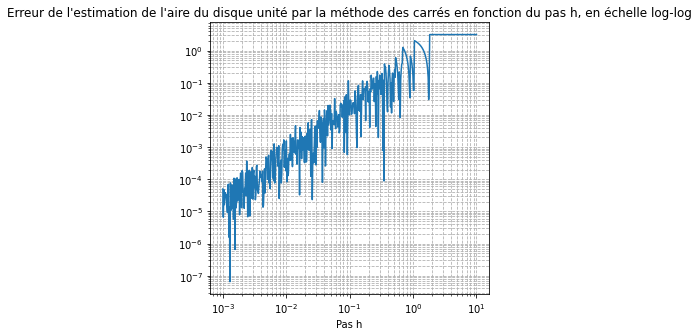

In [62]:
def courbe_erreur_estimation_aire(hmin_log_10,N):
    tabh = np.logspace(hmin_log_10, 1, N)
    erreur = np.abs(vect_aire_disque_unite(tabh) - np.pi)
    plt.plot(tabh,erreur)
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True,which="both", linestyle='--')
    plt.xlabel('Pas h')
    plt.title("Erreur de l'estimation de l'aire du disque unité par la méthode des carrés en fonction du pas h, en échelle log-log")
    plt.show()

courbe_erreur_estimation_aire(-3,500)

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [63]:
## AMELIORATION DE L'ESTIMATION
# Parmi les cubes h*h, qui contribuent à l'aire de K, certains ne sont pas complètement contenus dans K, puisque, pour un cube seul, le milieu doit appartenir à K pour qu'il puisse contribuer à l'aire de K. De même certains cubes ne comptent pas pour l'aire de K alors que leur milieu est très proche de la frontière de K et que K les recoupe.
# CRITERE RETENU :
# 1 - Un cube h*h contribue à l'approximation inférieure de l'aire si tous ses sommets sont contenus dans K.
# 2 - Un cube h*h contribue à l'approximation supérieure de l'aire si au moins un de ses sommets est contenu dans K.


def affichage_constat_et_explication():
    print("CONSTAT SUR LES LIMITES DE L'ESTIMATION PRECEDENTE")
    print("Parmi les cubes h*h, qui contribuent à l'aire de K, certains ne sont pas complètement contenus dans K, puisque, pour un cube seul, le milieu doit appartenir à K pour qu'il puisse contribuer à l'aire de K. De même certains cubes ne comptent pas pour l'aire de K alors que leur milieu est très proche de la frontière de K et que K les recoupe.")
    print("\nAMELIORATION DE L'ESTIMATION DE L'AIR\nLes critères retenus sont :\n1- Un cube h*h contribue à l'approximation inférieure de l'aire si tous ses sommets sont contenus dans K\n2- Un cube h*h contribue à l'approximation supérieure de l'aire si au moins un de ses sommets est contenu dans K\n")

affichage_constat_et_explication()

CONSTAT SUR LES LIMITES DE L'ESTIMATION PRECEDENTE
Parmi les cubes h*h, qui contribuent à l'aire de K, certains ne sont pas complètement contenus dans K, puisque, pour un cube seul, le milieu doit appartenir à K pour qu'il puisse contribuer à l'aire de K. De même certains cubes ne comptent pas pour l'aire de K alors que leur milieu est très proche de la frontière de K et que K les recoupe.

AMELIORATION DE L'ESTIMATION DE L'AIR
Les critères retenus sont :
1- Un cube h*h contribue à l'approximation inférieure de l'aire si tous ses sommets sont contenus dans K
2- Un cube h*h contribue à l'approximation supérieure de l'aire si au moins un de ses sommets est contenu dans K




ESTIMATION AVEC ENCADREMENT


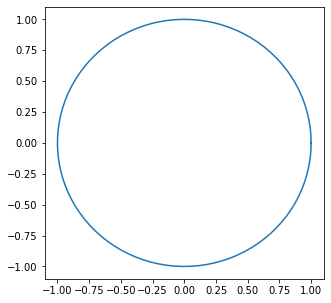

L'aire du disque unité est contenue dans l'intervalle [3.1395845,3.1435855] de longueur 0.004001000000000143


In [64]:
def area_squares_avec_encadrement(f, c, h, carre):
    """
    carre est un tupple contenant la position du sommet en bas à gauche du carré dans lequel K est plongé et la longeur des côtés.
    Par exemple, carre = ((0.0,1.0),5.0)
    Il est recommandé de plonger K dans un carré ne possant pas de problème au bord.
    """
    cx0,cy0, cote = carre[0][0], carre[0][1], carre[1]
    Nb = m.ceil(cote/h)
    cotebis = h*Nb
    
    mail1 = np.zeros((Nb+1, Nb+1))
    mail1 += cx0
    colonne_abscisse = np.linspace(0, cotebis, Nb+1)
    mail1 += colonne_abscisse
    
    mail2 = np.zeros((Nb+1, Nb+1))
    mail2 += cx0
    ligne_ordonnee = cotebis - colonne_abscisse.reshape((Nb+1,1))
    mail2 += ligne_ordonnee
    
    maillage = f(mail1,mail2)
    maillage = maillage <= c # une matrice de booléen
    
    tab_approximation_superieure = maillage[0:Nb,0:Nb] | maillage[1:Nb+1,0:Nb] | maillage[0:Nb,1:Nb+1] | maillage[1:Nb+1,1:Nb+1]
    approximation_superieure = np.sum(tab_approximation_superieure) * h**2
    
    tab_approximation_inferieure = maillage[0:Nb,0:Nb] & maillage[1:Nb+1,0:Nb] & maillage[0:Nb,1:Nb+1] & maillage[1:Nb+1,1:Nb+1]
    approximation_inferieure = np.sum(tab_approximation_inferieure) * h**2
    return [approximation_inferieure, approximation_superieure]


def aire_disque_unite_avec_encadrement(h):
    print('\nESTIMATION AVEC ENCADREMENT')
    aire = aire_disque_unite(h)
    X = np.cos(np.linspace(0, 2 * np.pi, 100))
    Y = np.sin(np.linspace(0, 2 * np.pi, 100))
    plt.plot(X, Y)
    plt.show()
    def f4(x,y):
        return x**2 + y**2
    estimation = area_squares_avec_encadrement(f4,1,h,((-1.1,-1.1),2.5))
    print(f"L'aire du disque unité est contenue dans l'intervalle [{estimation[0]},{estimation[1]}] de longueur {estimation[1] - estimation[0]}")

aire_disque_unite_avec_encadrement(0.0005)

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [70]:
# Pour des raisons d'intrications entre les paramètres delta et eps nous avons choisi de redéfinir
# les fonctions next_point et level_curve_advanced pour que celles-ci soient adaptées à la méthode des triangles.


def Newton(F, x0, y0, eps=eps, N=N):
    for i in range(N):
        resol_sys = - alg.solve(J(F)(x0,y0),F(x0,y0))
        # On supposera que F renvoye un ndarray
        x, y = x0 + resol_sys[0] , y0 + resol_sys[1]
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")
        

def next_point_tr(f, x0, y0,c, delta):
    
    def F(x, y):
        return np.array([f(x, y) - c, (x-x0)**2 + (y-y0)**2 - delta**2])
    
    g_fx, g_fy = grad(f)(x0, y0)[0], grad(f)(x0, y0)[1]
    norme = m.sqrt(g_fx**2 + g_fy**2)
    x_int, y_int = x0 + delta*g_fy/norme, y0 -delta*g_fx/norme
    x, y = Newton(F, x_int, y_int, eps = delta /100)
    return x, y


def level_curve_advanced_tr(f, x0, y0, delta, N, eps=eps):
    x1, y1 = x0, y0
    l = [[x0, y0]]
    for i in range(N):
        x, y = next_point_tr(f, x1, y1, f(x1, y1), delta)
        x1, y1 = x, y
        l.append([x, y])
        if i > 5 and (np.sqrt((x-x0)**2 + (y-y0)**2) < delta/10)  :
            l.append([x0, y0])
            return np.array(l)
    return np.array(l)


def area_U_n_by_triangle_method(p, delta, Nb):
    """ p est de la forme p=[xp,yp]"""
    
    # Recherche de la ligne de niveau
    def circle(x, y):
        return x**2 + y**2 - 1
    
    l = level_curve_advanced_tr(circle, 1., 0., delta, Nb)
    X = l[:, 0]
    Y = l[:, 1]
    
    # calcul de l'aire associée
    def area_1triangle(X, Y):
        u = [X[1] - X[0], Y[1]-Y[0]] #vecteur qui va du point p au point zi
        v = [X[2] - X[0], Y[2]-Y[0]] #vecteur qui va du point p au point zi+1
        return 0.5 * alg.det(np.array([u, v]))

    aire = 0
    for i in range(len(X)-1):
        aire += -area_1triangle([p[0], X[i], X[i+1]], [p[1], Y[i], Y[i+1]])
    
    return aire

ESTIMATION DE L'AIRE PAR LA METHODE DES TRIANGLES
Pour un point intérieur de coordonnées(0.5,0.5), et pour un pas  de 0.001 entre les points successifs de la courbe, l'aire du disque unité par la méthode des triangles est : 3.1415460709009673


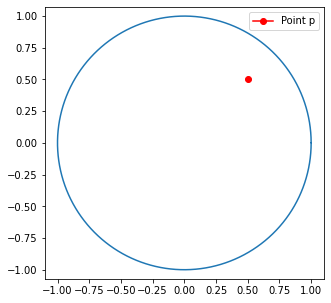

In [71]:
# Calcul de l'aire du disque unité
print("ESTIMATION DE L'AIRE PAR LA METHODE DES TRIANGLES")
xp, yp = 0.5, 0.5
delt = 0.001
Nb = int(2*np.pi/delt)
aire = area_U_n_by_triangle_method([xp, yp], delt, Nb)
print(f"Pour un point intérieur de coordonnées({xp},{yp}), et pour un pas  de {delt} entre les points successifs de la courbe, l'aire du disque unité par la méthode des triangles est : {aire}")

# Représentation graphique
def circle(x, y):
    return x**2 + y**2 - 1

l = level_curve_advanced_tr(circle, 1., 0., 0.01, int(2*np.pi/0.01))

plt.figure()
plt.axis('equal')
plt.plot(l[:, 0], l[:, 1])
plt.plot(xp, yp, marker= 'o', color= 'r', label = 'Point p')
plt.legend()
plt.show()

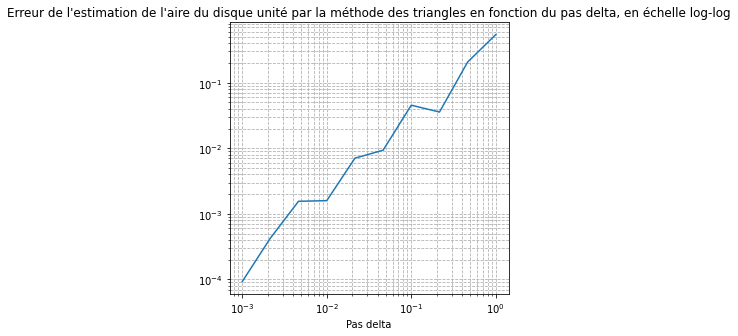

Conjecture sur la vitesse de convergence : la vitesse de convergence semble linéaire en le pas delta.



In [72]:
# Etude de la vitesse de convergence
def etude_de_la_precision_de_convergence(delta_min_log10):
    lg = 10
    tab_delta = np.logspace(delta_min_log10,0,lg)
    xp, yp = 0.,0.
    tab_Nb = (2*np.pi/tab_delta).astype(int)
    
    tab_erreur = []
    for i in range(lg):
        tab_erreur.append(np.abs(np.pi - area_U_n_by_triangle_method([xp,yp], tab_delta[i], tab_Nb[i])))
    
    plt.plot(tab_delta,tab_erreur)
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True,which="both", linestyle='--')
    plt.xlabel('Pas delta')
    plt.title("Erreur de l'estimation de l'aire du disque unité par la méthode des triangles en fonction du pas delta, en échelle log-log")
    plt.show()
    print("Conjecture sur la vitesse de convergence : la vitesse de convergence semble linéaire en le pas delta.\n")

etude_de_la_precision_de_convergence(-3)

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

CALCUL DE L'AIRE EN PRENANT UN POINT A L'EXTERIEUR
En prenant un point p à l'extérieur, et pour un pas  de 0.001 entre les points successifs de la courbe, l'aire du disque unité par la méthode des triangles est : 3.141592140568515
Ce résultat est pertinent.


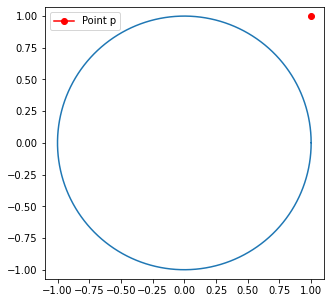

EXPLICATION : Dans l'estimation de l'aire d'un petit triangle, nous avons utiliser le calcul du déterminant de la famille de vecteur (pZ(i), pZ(i+1)) où Z(k) sont les points de la ligne de niveau. Ce déterminant est calculé dans la base canonique de R², uen base décrétée directe(au choix).
Ainsi, tous les angles sont orientés et les calculs d'aire sont algébrisés. Avoir un point de référence p à l'extérieur ou à l'intérieur ne change pas le sens d'orientation de l'angle (pZ(i),pZ(i+1)).

REMARQUE IMPORTANTE : CAS NON CONNEXE :
Dans le cas où K est convexe c'est précisément parce que les aires sont algébrisées par l'orientation de l'angle (pZ(i), pZ(i+1)) que des retranchements sont faits pour compenser des aires comptées plusieurs fois. L'aire d'un triangle est comptée négativement lorsque (pZ(i), pZ(i+1)) est orientée dans le sens trigonométrique et positionnement dans le cas contraire. Dire que K n'est pas connexe revient à dire que l'angle (pZ(k), pZ(k+1)) a pu 'tourner' pour certai

In [76]:
# Testons la méthode de calcul de l'aire par une somme d'aire de triangles, en prenant cette fois-ci un point à l'extérieur
xp, yp = 1.0, 1.0
delt = 0.001
Nb = int(2*np.pi/delt)
aire = area_U_n_by_triangle_method([xp, yp], delt, Nb )

print(f"CALCUL DE L'AIRE EN PRENANT UN POINT A L'EXTERIEUR\nEn prenant un point p à l'extérieur, et pour un pas  de {delt} entre les points successifs de la courbe, l'aire du disque unité par la méthode des triangles est : {aire}")
print("Ce résultat est pertinent.")

# Représentation graphique
def circle(x, y):
    return x**2 + y**2 - 1

l = level_curve_advanced_tr(circle, 1., 0., 0.01, int(2*np.pi/0.01))

plt.figure()
plt.axis('equal')
plt.plot(l[:, 0], l[:, 1])
plt.plot(xp, yp, marker= 'o', color= 'r', label = 'Point p')
plt.legend()
plt.show()

# Explication
text_explication = "EXPLICATION : Dans l'estimation de l'aire d'un petit triangle, nous avons utiliser le calcul du déterminant de la famille de vecteur (pZ(i), pZ(i+1)) où Z(k) sont les points de la ligne de niveau. Ce déterminant est calculé dans la base canonique de R², uen base décrétée directe(au choix).\nAinsi, tous les angles sont orientés et les calculs d'aire sont algébrisés. Avoir un point de référence p à l'extérieur ou à l'intérieur ne change pas le sens d'orientation de l'angle (pZ(i),pZ(i+1)).\n\nREMARQUE IMPORTANTE : CAS NON CONNEXE :\nDans le cas où K est convexe c'est précisément parce que les aires sont algébrisées par l'orientation de l'angle (pZ(i), pZ(i+1)) que des retranchements sont faits pour compenser des aires comptées plusieurs fois. L'aire d'un triangle est comptée négativement lorsque (pZ(i), pZ(i+1)) est orientée dans le sens trigonométrique et positionnement dans le cas contraire. Dire que K n'est pas connexe revient à dire que l'angle (pZ(k), pZ(k+1)) a pu 'tourner' pour certains k"
print(text_explication)

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [66]:
## Implémentation area_triangles
def area_triangles(x, y, p):
    
    def aire_1triangle(X, Y):
        u = [X[1] - X[0], Y[1]-Y[0]] #vecteur qui va du point p au point zi
        v = [X[2] - X[0], Y[2]-Y[0]] #vecteur qui va du point p au point zi+1
    return 0.5 * alg.det(np.array([u, v]))

    aire = 0
    for i in range(len(x)-1):
        aire += -aire_1triangle([p[0], x[i], x[i+1]], [p[1], y[i], y[i+1]])
    return aire

COHERENCE DES DEUX METHODES
Vérifions sur l'exemple précédent que les deux méthodes sont cohérentes.


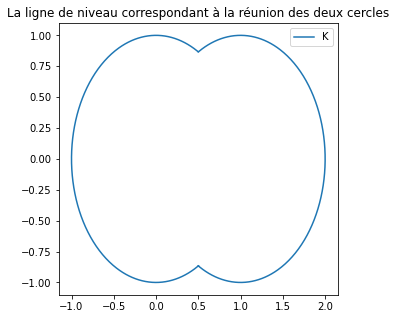

In [77]:
## Comparaison
text_demarche ="COHERENCE DES DEUX METHODES\nVérifions sur l'exemple précédent que les deux méthodes sont cohérentes."
print(text_demarche)

# Représentation graphique de K
def circle1(x, y):
    return x**2 + y**2 - 1

def circle2(x,y):
    return (x-1)**2 + y**2 - 1

delt = 0.01
Nb = int(2*np.pi/delt)

ligne1 = level_curve_advanced_tr(circle1, 1/2, - np.sqrt(3)/2, delt, Nb)
ligne2 = level_curve_advanced_tr(circle2, 1/2 , + np.sqrt(3)/2 , delt, Nb)

reunion_ligne  = [ligne1[0]]
cur  = 1
while (ligne1[cur][0]< 1/2):
    cur += 1
    reunion_ligne.append(ligne1[cur])
reunion_ligne.append(ligne2[0])
cur = 1

while (ligne2[cur][0]> 1/2):
    cur += 1
    reunion_ligne.append(ligne2[cur])
reunion_ligne.append(ligne1[0])
reunion_ligne = np.array(reunion_ligne)

plt.plot(reunion_ligne[0:,0], reunion_ligne[0:,1], label = "K")
plt.title('La ligne de niveau correspondant à la réunion des deux cercles')
plt.legend()
plt.show()


In [92]:
# Calcul de l'aire de K par la méthode des triangles
aire_reunion_triangle = area_triangles(reunion_ligne[0:,0], reunion_ligne[0:,1], [0., 4.])
print(f"Par la méthode des triangles appliquée à la ligne de niveau correspondant à K, on obtient comme aire : {aire_reunion_triangle} pour un pas deltat valant {delt}.")

# Calcul de l'aire de l'aire de K par la méthode des rectangles
print("\nPour le calcul de l'aire par la méthode des rectangles il faut faire prendre garde que la méthode prend comme critère une fonction. On a posé la bonne fonction qui décrit K (voir code).")

def f_reunion(x,y):
    return min(x**2 + y**2 , (x-1)**2 + y**2 )

vect_f_reunion = np.vectorize(f_reunion)
h = 0.01

aire_reunion_rectangle = area_squares(vect_f_reunion, 1, h, ((-1.25,-1.25), 3.5))

print(f"L'aire obtenue par la méthode des triangles est : {aire_reunion_rectangle} pour des cubes de côté h = {h}")
print("CONCLUSION : les deux méthodes sont cohérentes.")

Par la méthode des triangles appliquée à la ligne de niveau correspondant à K, on obtient comme aire : 5.054746966314461 pour un pas deltat valant 0.01.

Pour le calcul de l'aire par la méthode des rectangles il faut faire prendre garde que la méthode prend comme critère une fonction. On a posé la bonne fonction qui décrit K (voir code).
L'aire obtenue par la méthode des triangles est : 5.054 pour des cubes de côté h = 0.01
CONCLUSION : les deux méthodes sont cohérentes.


In [85]:
#Comparaisons des temps d'exécutions des méthodes pour un niveau de précision identique
import time

def etude_temps_execution(delta_min_log10):
    lg = 10
    tab_delta = np.logspace(delta_min_log10,0,lg)
    xp, yp = 0.,0.
    tab_Nb = (2*np.pi/tab_delta).astype(int)
    
    # temps d'éxécution de la mthde des triangles
    tab_time_triangle= []
    for i in range(lg):
        startTime = time.time()
        area_U_n_by_triangle_method([xp,yp], tab_delta[i], tab_Nb[i])
        endTime = time.time() - startTime
        tab_time_triangle.append(endTime)
    plt.plot(tab_delta,tab_time_triangle, label = 'Méthode des triangles')
 #   plt.yscale('log')
 #   plt.xscale('log')
    
    # temps d'éxécution de la mthde des rectangles
    def aire_disque_unite(h):
        def f4(x,y):
            return x**2 + y**2
        return area_squares(f4,1,h,((-1.1,-1.1),2.5))
    tab_h = np.logspace(delta_min_log10,0,lg)
    tab_time_carre= []
    for i in range(lg):
        startTime = time.time()
        aire_disque_unite(tab_h[i])
        endTime = time.time() - startTime
        tab_time_carre.append(endTime)
    plt.plot(tab_delta,tab_time_carre, label = 'Méthode des carrés')
    
    plt.title("Temps d'exécution de la méthode des triangles/rectangles en fonction du pas delta/côté h entre deux points consécutifs, pour l'estimation de l'aire du disque unité ")
    plt.xlabel('Pas delta / côté h')
    plt.ylabel("Temps d'exécution (en s.)")
    plt.grid(True,which="both", linestyle='--')
    plt.legend()
    plt.show()




COMPARAISON DES DUREES D'EXECUTION DES METHODES :
Nous allons à présent comparer la rapidité des méthodes.
Une expérience est faite dans le cadre de l'estimation de l'aire du disque unité.

Obervation de la courbe : Pour un niveau de précision environ équivalent (se rapporter aux courbes sur la précison de la méthode des retangles/triangles dasn l'estimation de l'aire du disque unité), la figure montre que la méthode des rectangles est plus rapide.

Explication : il faut cependant nuancer cette observation. La méthode des triangles est couteuse en temps parce qu'il faut déterminer la ligne de niveau associé.

---> En revanche il faut bien nuancer le fait que lorsque la ligne de niveau est déterminée, le calcul de l'aire par la méthode des triangles peut se réveler moins couteux et plus efficace, car il pourrait nécessiter moins d'opérations que pour l'ensemble du pavage de la méthode des rectangles.


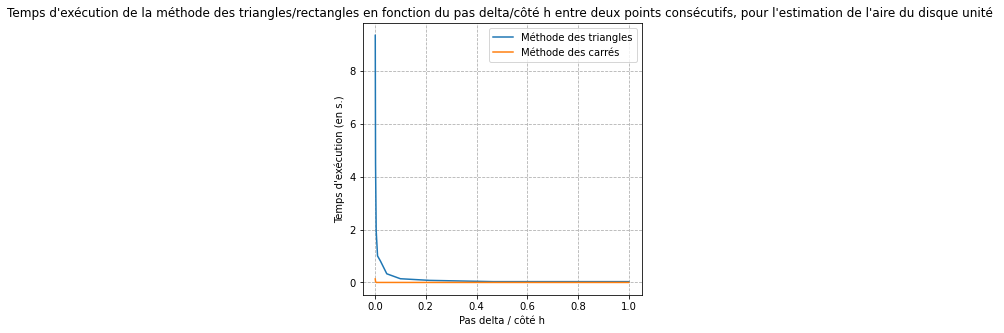

In [87]:
demarche_text = "\n\n\nCOMPARAISON DES DUREES D'EXECUTION DES METHODES :\nNous allons à présent comparer la rapidité des méthodes.\nUne expérience est faite dans le cadre de l'estimation de l'aire du disque unité."
observation_text = "\nObervation de la courbe : Pour un niveau de précision environ équivalent (se rapporter aux courbes sur la précison de la méthode des retangles/triangles dasn l'estimation de l'aire du disque unité), la figure montre que la méthode des rectangles est plus rapide."
explication_text = "\nExplication : il faut cependant nuancer cette observation. La méthode des triangles est couteuse en temps parce qu'il faut déterminer la ligne de niveau associé."
nuancer_text = "\n---> En revanche il faut bien nuancer le fait que lorsque la ligne de niveau est déterminée, le calcul de l'aire par la méthode des triangles peut se réveler moins couteux et plus efficace, car il pourrait nécessiter moins d'opérations que pour l'ensemble du pavage de la méthode des rectangles."
print(demarche_text)    
print(observation_text)
print(explication_text)
print(nuancer_text)

etude_temps_execution(-3)

In [88]:
# Avantages et inconvénients de la méthode des rectangles/triangles
print("\n\nAVANTAGES ET INCONVENIENTS DES METHODES")
print("\nLa méthode des triangles :\n- est particulièrement utile lorsqu'une ligne de niveau est connue, le calcul de l'aire n'étant alors qu'une somme d'aires de triangles, qui peut être implémenter par des ufunc et des tableaux numpy\n-lorsque la ligne de niveau est connue mais qu'il est impossible de déterminer une fonction de classe C^1 permettant d'avoir un critère f(x,y) <= c, la méthode des triangles est à privilégier par rapport à la méthode des rectangles\n- 1er inconvénient : déterminer une ligne de niveau via level_curve advanced peut s'avérer couteux en temps\n- 2ème inconvénient : level_curve_advanced ne permet de déterminer qu'une seule ligne de niveau après l'autre. Par conséquent, lorsque K possède plusieurs composantes connexes par arc la méthode des rectangles peut s'avérer plus simple à mannier.")
print("\nLa méthode des recatngles : \n- est bien optimisée car vectorisée\n-est particulièrement utile lorsque K possède plusieurs composantes connexes par arc (par exemple pour la fonction f3 : la méthode des triangles ne peut pas s'appliquer pour déterminer l'aire de K = ((x,y) | f3(x,y) <= 1))\n-nécessite de caractériser K à l'aide d'une inégalité sur une fonction f C^1, donc de connaître analytiquement f\n-donne un encadrement de l'aire donc un intervalle de confiance\n- 1 inconvénient : est très couteuse en mémoire et en temps lorsque h diminue")



AVANTAGES ET INCONVENIENTS DES METHODES

La méthode des triangles :
- est particulièrement utile lorsqu'une ligne de niveau est connue, le calcul de l'aire n'étant alors qu'une somme d'aires de triangles, qui peut être implémenter par des ufunc et des tableaux numpy
-lorsque la ligne de niveau est connue mais qu'il est impossible de déterminer une fonction de classe C^1 permettant d'avoir un critère f(x,y) <= c, la méthode des triangles est à privilégier par rapport à la méthode des rectangles
- 1er inconvénient : déterminer une ligne de niveau via level_curve advanced peut s'avérer couteux en temps
- 2ème inconvénient : level_curve_advanced ne permet de déterminer qu'une seule ligne de niveau après l'autre. Par conséquent, lorsque K possède plusieurs composantes connexes par arc la méthode des rectangles peut s'avérer plus simple à mannier.

La méthode des recatngles : 
- est bien optimisée car vectorisée
-est particulièrement utile lorsque K possède plusieurs composantes connexes p